In [81]:
import pandas as pd
import numpy as np

## 데이터 전처리 (data_preprocessing.ipynb)
* Date Split
* Weekday
* Lunar Date
* Date Normalization
* 식사명 -> one-hot
* 식사내용 -> bag-of-word

In [176]:
# Read Data
df = pd.read_excel("../data/train.xlsx")

In [177]:
df.head()

,일자,식사명,식사내용,수량
0,20030301,아침,"과일샐러드,닭죽,돈육마늘장조림,떡만두국,부추김무침,쌀밥,딸기잼(중),비엔나구이,스크...",37.472924
1,20030301,저녁,"감자으깸샐러드,비프까스,스위트피클,쌀밥,옥수수스프",19.566787
2,20030301,점심(일반),"골뱅이야채무침,새우맛살튀김,쌀밥(사무직),열무겉절이,칼국수",31.191336
3,20030302,아침,"계란죽,곤약멸치조림,김치국,마카로니샐러드,쌀밥,오징어회무침,딸기잼(중),삶은계란,야...",36.101083
4,20030302,저녁,"계란탕,단무지잔파무침,자장소스,잡채밥,탕수만두",21.949458


In [178]:
def add_weather(df):
    weather = pd.read_excel("../data/[과제3] 관련. 포항지역 날씨 데이터(03~17).xlsx")
    weather['일시'] = [int(x.strftime("%Y%m%d")) for x in weather['일시']]
    
    drop_list = ["지점"]
    for x in weather.columns:
        if weather[x].isnull().sum() > 500:
            drop_list.append(x)
        elif weather[x].isnull().sum() < len(weather):
            weather[x].interpolate(inplace=True)
            if x != '일시':
                weather[x] = weather[x].shift(3)
    weather.drop(drop_list, axis=1, inplace=True)
    
    df = pd.merge(df, weather, how='left', left_on='일자', right_on='일시')
    df.drop(['일시'], axis=1, inplace=True)
    
    return df

In [179]:
# 식사명 변환 (one-hot)
def convert_ont_hot(df):
    df = df.join(pd.get_dummies(df['식사명'], prefix='식사명'))
    df.drop(['식사명'], axis=1, inplace=True)
    return df

In [180]:
def moving_average(df):
    def ma_window(df, window_size):
        morning = df['수량'][df['식사명_아침']==1].rolling(window_size, min_periods=1).mean().shift(3)
        lunch = df['수량'][df['식사명_점심(일반)']==1].rolling(window_size, min_periods=1).mean().shift(3)
        lunch_west = df['수량'][df['식사명_점심(양식)']==1].rolling(window_size, min_periods=1).mean().shift(3)
        dinner = df['수량'][df['식사명_저녁']==1].rolling(window_size, min_periods=1).mean().shift(3)    
        return pd.concat([morning, lunch, lunch_west, dinner]).sort_index()
    df['MA_1day'] = ma_window(df, 1)
    df['MA_3day'] = ma_window(df, 3)
    df['MA_5day'] = ma_window(df, 5)
    df['MA_week'] = ma_window(df, 7)
    df['MA_month'] = ma_window(df, 30)
    df['MA_half_year'] = ma_window(df, 180)
    df['MA_year'] = ma_window(df, 365)
    df.drop(df[df.일자 < 20040326].index, inplace=True)
    df.drop(df[(df.일자 > 20050109) & (df.일자 < 20060331) & (df['식사명_점심(양식)']==1)].index, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [181]:
# 식사내용 변환 (Bag-of-Word)
from sklearn.feature_extraction.text import CountVectorizer
import konlpy

def menu_dictionary(menu_list):
    def tokenize(text):
        text = text.replace('.', ',')
        text = text.replace('/', ',')
        text = text.replace('&', ',')
        return text.split(',')
    menu = []
    for m in menu_list:
        for mm in tokenize(m):
            mm = re.sub('\(.*?\)', '', mm)
            mm = re.sub('[0-9a-zA-Z]', '', mm)
            menu.append(mm)
    menu = list(set(menu))
    
    okt = konlpy.tag.Kkma()
    menu_morphs = []
    for m in menu:
        menu_morphs += okt.morphs(m)
    menu_morphs = list(set(menu_morphs))
    return menu_morphs

def convert_bow(df):
    menu_dic = menu_dictionary(df['식사내용'])
    vectorizer = CountVectorizer(vocabulary=menu_dic)
    bow = vectorizer.transform(df['식사내용']).toarray()
    df = df.join(pd.DataFrame(bow, columns=vectorizer.get_feature_names()))
    df.drop(['식사내용'], axis=1, inplace=True) 
    return df

In [182]:
# 년/월/일 분리(split) + 요일(Weekday) 추가
def split_date(df):
    # Normalize Date
    df['year'] = (df['일자'] / 10000).astype(int)
    df['month'] = (df['일자'] % 10000 / 100).astype(int)
    df['day'] = (df['일자'] % 100).astype(int)
    df['weekday'] = pd.to_datetime(df['일자'], format = '%Y%m%d').dt.dayofweek
    return df

In [183]:
# 음력 추가
from korean_lunar_calendar import KoreanLunarCalendar
from datetime import datetime

def add_lunar_date(df):
    calendar = KoreanLunarCalendar()
    
    lunar_y = []
    lunar_m = []
    lunar_d = []
    for y, m, d in zip (df['year'], df['month'], df['day']):
        calendar.setSolarDate(y, m, d)
        lunar_date = calendar.LunarIsoFormat()
        lunar_y.append(int(lunar_date[:4]))
        lunar_m.append(int(lunar_date[5:7]))
        lunar_d.append(int(lunar_date[8:10]))
        
    df['lunar_year'], df['lunar_month'], df['lunar_day'] = lunar_y, lunar_m, lunar_d
    return df

In [184]:
# 년/월/일 변환
def year_norm(df):
    df['year'] = (df['year']-min(df['year'])) / (max(df['year'])-min(df['year']))
    df['lunar_year'] = (df['lunar_year']-min(df['lunar_year'])) / (max(df['lunar_year'])-min(df['lunar_year']))
    return df
def month_norm(df):
    df['month_sin'] = [np.sin(x*2*np.pi/12) for x in df['month']]
    df['month_cos'] = [np.cos(x*2*np.pi/12) for x in df['month']]
    df['lunar_month_sin'] = [np.sin(x*2*np.pi/12) for x in df['lunar_month']]
    df['lunar_month_cos'] = [np.cos(x*2*np.pi/12) for x in df['lunar_month']]
    df.drop(['month', 'lunar_month'], axis=1, inplace=True)
    return df
def day_norm(df):
    df['day_sin'] = [np.sin(x*2*np.pi/31) for x in df['day']]
    df['day_cos'] = [np.cos(x*2*np.pi/31) for x in df['day']]
    df['lunar_ay_sin'] = [np.sin(x*2*np.pi/31) for x in df['lunar_day']]
    df['lunar_day_cos'] = [np.cos(x*2*np.pi/31) for x in df['lunar_day']]
    df.drop(['day', 'lunar_day'], axis=1, inplace=True)
    return df
def weekday_norm(df):
    df['weekday_sin'] = [np.sin(x*2*np.pi/7) for x in df['weekday']]
    df['weekday_cos'] = [np.cos(x*2*np.pi/7) for x in df['weekday']]
    return df

In [185]:
# add Weather Information
df = add_weather(df)

# convert 식사명 to one-hot
df = convert_ont_hot(df)

# Moving Average of 수량
df = moving_average(df)

# convert 식사내용 to Bag-of-Word Vector
df = convert_bow(df)

# Date
df = split_date(df)
df = add_lunar_date(df)

# Date Normalization
df = year_norm(df)
df = month_norm(df)
df = day_norm(df)
df = weekday_norm(df)

In [186]:
print("Number of Columns =", len(df.columns))
df.head()

Number of Columns = 1034


,일자,수량,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),최대 순간 풍속(m/s),최대 순간 풍속 풍향(16방위),최대 순간풍속 시각(hhmi),...,month_sin,month_cos,lunar_month_sin,lunar_month_cos,day_sin,day_cos,lunar_ay_sin,lunar_day_cos,weekday_sin,weekday_cos
0,20040326,41.877256,10.5,4.6,439.0,17.6,1413.0,10.0,180.0,1620.0,...,1.0,6.123234e-17,0.866025,0.5,-0.848644,0.528964,0.937752,0.347305,-0.433884,-0.900969
1,20040326,13.718412,10.5,4.6,439.0,17.6,1413.0,10.0,180.0,1620.0,...,1.0,6.123234e-17,0.866025,0.5,-0.848644,0.528964,0.937752,0.347305,-0.433884,-0.900969
2,20040326,40.361011,10.5,4.6,439.0,17.6,1413.0,10.0,180.0,1620.0,...,1.0,6.123234e-17,0.866025,0.5,-0.848644,0.528964,0.937752,0.347305,-0.433884,-0.900969
3,20040327,37.184116,11.5,7.2,702.0,15.6,1316.0,8.2,270.0,1333.0,...,1.0,6.123234e-17,0.866025,0.5,-0.724793,0.688967,0.988468,0.151428,-0.974928,-0.222521
4,20040327,12.635379,11.5,7.2,702.0,15.6,1316.0,8.2,270.0,1333.0,...,1.0,6.123234e-17,0.866025,0.5,-0.724793,0.688967,0.988468,0.151428,-0.974928,-0.222521


In [2]:
# Read Data
import pandas as pd
temp = pd.read_excel("../data/train.xlsx")

In [9]:
import konlpy
import re
def menu_dictionary(menu_list):
    def tokenize(text):
        text = text.replace('.', ',')
        text = text.replace('/', ',')
        text = text.replace('&', ',')
        return text.split(',')
    menu = []
    for m in menu_list:
        for mm in tokenize(m):
            mm = re.sub('\(.*?\)', '', mm)
            mm = re.sub('[0-9a-zA-Z]', '', mm)
            menu.append(mm)
    menu = list(set(menu))
    
    okt = konlpy.tag.Okt()
    menu_morphs = []
    for m in menu:
        menu_morphs += okt.morphs(m)
    menu_morphs = list(set(menu_morphs))
    return menu_morphs

In [202]:
def bow(df, dic):

SyntaxError: unexpected EOF while parsing (<ipython-input-202-0dead56d339b>, line 1)

In [10]:
len(menu_dictionary(temp['식사내용']))

998

In [11]:
for x in menu_dictionary(temp['식사내용']):
    if len(x) > 1:
        print(x)

산적
사리
참두
콩국수
메추리
햄버거
떡국
도라지잔
반달
초장
검은
포도
애느타리
초회
굴밥
불닭
당면
아이스티
청포묵
두유
북어
지리
빵가루
생채
당근
돈목
개국
샐러
씨앗
아욱
기장
칼국수
새우
시마국
삼겹
람보
고사리
족발
닭다리
파리
수육
더덕
무굴
드래싱
뿌리채소
금구
알품
수수
죽순
잡채
짬뽕
멸치
콩밥
토마토소스
배추김치
호박
황도
호두과자
칠면조
아기
완제
아구찜
파닭
쉐이크
미소
생크림
생굴
잔파맛살
모자반
가지전
미니까
쭈닭
참치회
건문
홍초
치고
숙주
꽁치
닭탕수
참나물
찹쌀
밤죽
함박스테이크
조림
칡즙
빈대떡
도라지
강정
건빵
꽃빵
아이스
김치찌개
물김치
살구
튀김
리브
치킨텐
청량고추
두부김치
장조림
이면
잣죽
냉이
달걀
장탕
도루묵
사태
굴국
알곤
델리
무맛살
포고
비엔나
소세지
스튜
주스
마파두부
사무직
참깨
쥐포
시골
버터
잎쌈
피클
복신
비타민
코코
버터치킨
무채국
선듀
파채
닭고기
초코
재첩국
더운
짜박
팥밥
매운탕
땅콩
파절
조개
육개장
등심
맑은
신선한
현미
애플
부국
파워
타르
상치
양송이
곰탕
왕만
봄나물
돼지국밥
청양
토스트
비빔냉면
토핑
복숭아
로렐
경단
스크램블에그
고르
줄기
사용
참외
모듬
주식
칼슘
호박고지
오므라이스
자장
리전
살수
주먹밥
스파게티
하이라이스
스모크
양반
고추장
닭죽
파국
방닭
계란
복채
영양탕
치킨너겟
펀치
조미
불닭볶음면
산나물
묵전
돈까스
밤찜
크림소스
설탕
타리
양장
단호박
대국
미숫가루
근대
삼겹살
미니
인삼
데미
새송이
그린
육계
날치
느타리버섯
미역냉국
배추
우거지
피자
유자청
양념통닭
크림
고기국수
통감자구이
날개
돼지
열무
된장찌개
닭갈비
닭도리탕
카레
대나물
냉면
시금치
배즙
전갱이
쌀국수
저지방우유
비빔국수
볼탕수
메밀
낙지
굴국밥
생강
엽채
케일
수제
오이소박이
보리멸
양상추
돈부리
해물
코다리
홍시
케이준
송편
포도쥬스
애느타리버섯
그릴
옥수수
굴죽
비후까스
보쌈김치
나가사키
막대
계란말이
아구
계피
김구
멘치까
마파
밤밥
골뱅이
오이치
돌나물
깐풍기
설렁탕
파세
아오
단

In [151]:
temp['식사내용']

0        과일샐러드,닭죽,돈육마늘장조림,떡만두국,부추김무침,쌀밥,딸기잼(중),비엔나구이,스크...
1                              감자으깸샐러드,비프까스,스위트피클,쌀밥,옥수수스프
2                         골뱅이야채무침,새우맛살튀김,쌀밥(사무직),열무겉절이,칼국수
3        계란죽,곤약멸치조림,김치국,마카로니샐러드,쌀밥,오징어회무침,딸기잼(중),삶은계란,야...
4                                계란탕,단무지잔파무침,자장소스,잡채밥,탕수만두
5                     갈비탕,깍두기(손칼),두부달걀전,생선묵조림,쌀밥,오이,풋고추,쌈장
6        감자다시마국,녹두죽,멸치볶음,쇠고기팽이버섯볶음,쌀밥,우유,호박나물,딸기&쵸코우유,딸...
7                  꽈리고추찜,돈등심케찹조림,쌀밥,어묵양파볶음(K),열무된장무침,콩나물무국
8                        계란찜,냉이배추된장국,삼치엿장조림,시금치나물,쌀밥,콩나물무침
9        감자채볶음,고구마죽,동태무조림(가공),두부유부된장국,부추김무침,쌀밥,우유1,딸기&쵸...
10                      기장밥,꽁치양념구이,떡국,메추리알햄조림,미나리나물,미역줄기볶음
11                계란탕,깍두기(손칼),달래무생채,새우볶음밥,오징어회무침,요구르트,자장소스
12       닭죽(잔파),돈육두루치기,맛살조림,시금치나물,쌀밥,어묵무국,우유,딸기&쵸코우유,딸기...
13       감자오이샐러드,깍두기(손칼),닭파인애플조림(부분),도토리묵말이,상추겉절이,쌀밥,진미...
14                           마늘쫑지무침,새알미역국,새우동그랑땡,쭈꾸미볶음,흑미밥
15       만두국,소방어무조림,소세지야채볶음,쌀밥,열무된장무침,우유1,콩죽,딸기&쵸코우유,딸기...
16          감자채볶음,곰탕,깍두기(손칼),두부양념장구이(K),방울토마토,쌀밥,오이,풋고추,

In [13]:
def tokenize(text):
    text = text.replace('.', ',')
    text = text.replace('/', ',')
    text = text.replace('&', ',')
    return text.split(',')
menu = []
for m in menu_list:
    for mm in tokenize(m):
        mm = re.sub('\(.*?\)', '', mm)
        mm = re.sub('[0-9a-zA-Z]', '', mm)
        menu.append(mm)
menu = list(set(menu))

IndentationError: unindent does not match any outer indentation level (<ipython-input-13-fe2b90af37e4>, line 6)

In [106]:
norm = []

In [115]:
parrent = []
for i in range(len(list(set(menu)))):
    parrent.append(i)

In [12]:
offset=3

for i in range(0, len(menu)):
    for j in range(i+1, len(menu)):
        for k in range(0, len(menu[i])-offset+1):
            subseq = menu[i][k:k+offset]
            if subseq in menu[j]:
                print(subseq, menu[i], menu[j])
                norm.append(subseq)

NameError: name 'menu' is not defined

In [114]:
list(set(norm))

['열무된',
 '팽이부',
 '늘쫑',
 '새송이볶',
 '살미',
 '사키',
 '.양념',
 '은국',
 '주나물',
 '추치커리',
 '키위쥬스',
 '장아찌',
 '삼겹살볶',
 '잔멸치',
 '만두강',
 '해물',
 '건미',
 '고추볶',
 '지된장',
 '된장',
 '데미',
 '래무',
 '두부',
 '스조림',
 '자미튀',
 '감자간장조림',
 '어소금구',
 '꽃맛',
 '토리묵',
 '땡조림',
 '닭불',
 '어강정',
 '묵말',
 '념장구',
 '어소',
 '스볶음',
 '이버',
 '쑥갓무',
 '배추된장',
 '깐풍',
 '크램블에',
 '북어',
 '이초',
 '콩나물잡',
 '송이볶음',
 '러가지',
 '플라워',
 '가루',
 '게맛살샐러',
 '해파리냉',
 '송이버',
 '부추냉채',
 '키위쥬',
 '지무',
 '블에',
 '계란장조림',
 '박화채',
 '바베큐',
 '두튀김',
 '추냉채',
 '묵상추무',
 '우거',
 '타리쇠고',
 '어브로콜리',
 '엽채',
 '섯고',
 '무채',
 '애느',
 '전골',
 '타볶음',
 '산적',
 '코다',
 '부추양',
 '부찌개',
 '리구이',
 '하루',
 '맛살계',
 '콩나물겨자',
 '두강',
 '위쥬스',
 '묵쑥',
 '면사리',
 '깐마늘',
 '엔나',
 '김치덮',
 '고등어양',
 '미숫가루',
 '말이튀김',
 '드/',
 '파스타볶음',
 '고추볶음',
 '연두부',
 '허니버',
 '래기된',
 '애느타리버',
 '늘장아찌',
 '한방닭',
 '치볶',
 '리두',
 '타리버',
 '치고',
 '채볶음밥',
 '건파래',
 '단호박조',
 '방닭',
 '우거지',
 '리비',
 '기메추리알',
 '칼국',
 '나나',
 '황도',
 '부김치',
 '어브로콜',
 '호두',
 '묵쑥갓',
 '리알조림',
 '불고',
 '이피망',
 '고구마순',
 '자고추장찌개',
 '건새우볶',
 '장찌',
 '떡볶음',
 '무김',
 '미트',
 '메

In [15]:
cnt = []
for x in menu:
    cnt.append((x, df[x].sum()))

In [16]:
cnt.sort(key=lambda tup: tup[0])

In [17]:
cnt

[('1회용케찹+1회용허니', 1),
 ('MA_half_year', 430871.5728038507),
 ('MA_month', 428246.543922985),
 ('MA_year', 434590.4784135307),
 ('la갈비구이', 8),
 ('가리비젓갈', 1),
 ('가오리찜', 16),
 ('가자미구이', 164),
 ('가자미무조림', 170),
 ('가자미무조림(가공)', 19),
 ('가자미미역국', 1),
 ('가자미빵가루튀김', 6),
 ('가자미양념장구이', 8),
 ('가자미찜', 250),
 ('가자미찜2', 1),
 ('가자미카레튀김', 25),
 ('가자미튀김', 24),
 ('가자미튀김양념', 35),
 ('가지굴소스볶음', 27),
 ('가지깐풍', 18),
 ('가지나물', 343),
 ('가지냉국', 2),
 ('가지볶음', 17),
 ('가지볶음2', 8),
 ('가지쇠고기볶음', 27),
 ('가지전', 19),
 ('가지토마토소스볶음', 26),
 ('간장파닭', 2),
 ('갈릭산적고추장조림', 26),
 ('갈비만두(찐)', 23),
 ('갈비산적간장조림', 27),
 ('갈비탕', 75),
 ('갈치감자조림', 5),
 ('갈치구이', 33),
 ('갈치그릴구이', 198),
 ('갈치단호박조림', 7),
 ('갈치무조림', 305),
 ('갈치무조림(원양)', 1),
 ('갈치조림', 3),
 ('갈치찜', 13),
 ('갈치카레구이', 42),
 ('갈치호박조림', 73),
 ('감식초', 2),
 ('감자간장조림', 51),
 ('감자고르케', 2),
 ('감자고추장찌개', 35),
 ('감자고추장찌개(느타리)', 20),
 ('감자그라탕', 13),
 ('감자냉국', 12),
 ('감자냉이국', 3),
 ('감자다시마국', 15),
 ('감자당면찌개', 4),
 ('감자버터구이', 1),
 ('감자베이컨볶음', 29),
 ('감자베이컨조림', 18),
 ('감자비엔나조림', 46),
 ('감자샐러드'

In [126]:
df[df['딸기잼(중)']==1]

,일자,수량,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),최대 순간 풍속(m/s),최대 순간 풍속 풍향(16방위),최대 순간풍속 시각(hhmi),...,month_sin,month_cos,lunar_month_sin,lunar_month_cos,day_sin,day_cos,lunar_ay_sin,lunar_day_cos,weekday_sin,weekday_cos
1563,20050829,45.415162,24.1,19.6,437.0,29.1,1456.0,9.7,230.0,1038.0,...,-0.866025,-0.5,-0.5,-0.866025,-0.394356,0.918958,-0.937752,0.347305,0.0,1.0


In [3]:
temp = pd.read_excel("../data/train.xlsx")

In [129]:
temp['식사내용'][5]

'갈비탕,깍두기(손칼),두부달걀전,생선묵조림,쌀밥,오이,풋고추,쌈장'

In [119]:
# 식사내용 변환 (Bag-of-Word)
from sklearn.feature_extraction.text import CountVectorizer
cc = CountVectorizer(vocabulary=['계란죽','쌀밥'])

In [5]:
# 식사내용 변환 (Bag-of-Word)
from sklearn.feature_extraction.text import CountVectorizer
def convert_bow(df):
    def tokenize(text):
        return text.split(',')
    vectorizer = CountVectorizer(tokenizer=tokenize, ngram_range=(1,3))
    bow = vectorizer.fit_transform(df['식사내용']).toarray()
    df = df.join(pd.DataFrame(bow, columns=vectorizer.get_feature_names()))
    df.drop(['식사내용'], axis=1, inplace=True) 
    return df

In [181]:
import re
rep = []
for xx in temp['식사내용']:
    for xxx in re.split(pattern=' |&|\(|\)|,', string=xx):
        if xxx != "":
            rep.append(xxx)

In [182]:
rep

['과일샐러드',
 '닭죽',
 '돈육마늘장조림',
 '떡만두국',
 '부추김무침',
 '쌀밥',
 '딸기잼',
 '중',
 '비엔나구이',
 '스크램블에그',
 '경양식',
 '야채샐러드',
 '크림스프',
 '경양식',
 '토스트',
 '모닝빵',
 '감자으깸샐러드',
 '비프까스',
 '스위트피클',
 '쌀밥',
 '옥수수스프',
 '골뱅이야채무침',
 '새우맛살튀김',
 '쌀밥',
 '사무직',
 '열무겉절이',
 '칼국수',
 '계란죽',
 '곤약멸치조림',
 '김치국',
 '마카로니샐러드',
 '쌀밥',
 '오징어회무침',
 '딸기잼',
 '중',
 '삶은계란',
 '야채샐러드',
 '크림스프',
 '경양식',
 '토스트',
 '모닝빵',
 '후르츠펀치',
 '계란탕',
 '단무지잔파무침',
 '자장소스',
 '잡채밥',
 '탕수만두',
 '갈비탕',
 '깍두기',
 '손칼',
 '두부달걀전',
 '생선묵조림',
 '쌀밥',
 '오이',
 '풋고추',
 '쌈장',
 '감자다시마국',
 '녹두죽',
 '멸치볶음',
 '쇠고기팽이버섯볶음',
 '쌀밥',
 '우유',
 '호박나물',
 '딸기',
 '쵸코우유',
 '딸기잼',
 '중',
 '야채샐러드',
 '콘후레이크',
 '크림스프',
 '경양식',
 '토스트',
 '모닝빵',
 '후르츠펀치',
 '꽈리고추찜',
 '돈등심케찹조림',
 '쌀밥',
 '어묵양파볶음',
 'K',
 '열무된장무침',
 '콩나물무국',
 '계란찜',
 '냉이배추된장국',
 '삼치엿장조림',
 '시금치나물',
 '쌀밥',
 '콩나물무침',
 '감자채볶음',
 '고구마죽',
 '동태무조림',
 '가공',
 '두부유부된장국',
 '부추김무침',
 '쌀밥',
 '우유1',
 '딸기',
 '쵸코우유',
 '딸기잼',
 '중',
 '비엔나구이',
 '삶은계란',
 '야채샐러드',
 '크림스프',
 '경양식',
 '토스트',
 '모닝빵',
 '기장밥',
 '꽁치양념구이',
 '떡국',
 '메추리알햄조림',
 '미나리나물',
 '미역줄기볶음

In [8]:
import re
c = re.compile('[^ \u3131-\u3163\uac00-\ud7a3]+')
def tk(text):
    output = re.split(pattern=' |&|\(|\)|,', string=text)
    ll = []
    for o in output:
        print(c.match(o))
        if len(o) > 1:
            ll.append(o)
    return ll
v = CountVectorizer(tokenizer=tk)
v.fit(temp['식사내용'])
# b = v.transform(temp['식사내용']).toarray()
# tt = temp.join(pd.DataFrame(b, columns=v.get_feature_names()))

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='k'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
No

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 2), match='90'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match 

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match=':'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
No

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match=':'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
No

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='k'>
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='k'>
None
None
None
<_sre.SRE_Match object; span=(0, 3), match='70g'>
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='u'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match=':'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
No

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 2), match='40'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
N

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 3), match='180'>
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
N

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
Non

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 3), match='180'>
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
N

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
N

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
Non

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
N

None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
Non

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'

None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
Non

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='1'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
Non

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(

None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='i'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
No

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='2'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
No

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
<_sre.SRE_Match object; span=(0, 1), match='2'>
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
No

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tk at 0x7ff5ddb742f0>, vocabulary=None)

In [210]:
v.get_feature_names()

['-사용불가',
 '180',
 '1조각',
 '1회용',
 '1회용케찹+1회용허니',
 '2개씩',
 '40',
 '70',
 '70g',
 '90',
 ':사무직',
 ':연',
 'i중',
 'la갈비구이',
 '가공',
 '가리비젓갈',
 '가오리찜',
 '가자미구이',
 '가자미무조림',
 '가자미미역국',
 '가자미빵가루튀김',
 '가자미양념장구이',
 '가자미찜',
 '가자미찜2',
 '가자미카레튀김',
 '가자미튀김',
 '가자미튀김양념',
 '가지굴소스볶음',
 '가지깐풍',
 '가지나물',
 '가지냉국',
 '가지볶음',
 '가지볶음2',
 '가지쇠고기볶음',
 '가지오이냉국',
 '가지전',
 '가지토마토소스볶음',
 '간보호',
 '간장파닭',
 '갈릭산적고추장조림',
 '갈비만두',
 '갈비산적간장조림',
 '갈비살구이',
 '갈비탕',
 '갈치감자조림',
 '갈치구이',
 '갈치그릴구이',
 '갈치단호박조림',
 '갈치무조림',
 '갈치조림',
 '갈치찜',
 '갈치카레구이',
 '갈치호박조림',
 '감식초',
 '감자간장조림',
 '감자고르케',
 '감자고추장찌개',
 '감자그라탕',
 '감자냉국',
 '감자냉이국',
 '감자다시마국',
 '감자당면찌개',
 '감자맛탕',
 '감자버터구이',
 '감자베이컨볶음',
 '감자베이컨조림',
 '감자비엔나조림',
 '감자샐러드',
 '감자소세지볶음',
 '감자수제비국',
 '감자스모크햄볶음',
 '감자양파국',
 '감자오이샐러드',
 '감자육계조림',
 '감자으깸샐러드',
 '감자전',
 '감자조림',
 '감자채베이컨볶음',
 '감자채볶음',
 '감자채브로콜리볶음',
 '감자채카레볶음',
 '감자채피망볶음',
 '감자탕',
 '감자탕1',
 '감자튀김',
 '감자풋고추볶음',
 '건문어초무침',
 '건미역맛살초무침',
 '건미역무침',
 '건미역오이초무침',
 '건빵튀김',
 '건새우',
 '건새우마늘쫑볶음',
 '건새우무채국',
 '건새우볶음',
 '건새우아욱국',
 '건새우호박국',
 

In [193]:
for vv in v.get_feature_names():
    if vv == " 쥐포":
        print(vv)
    elif vv == "쥐포":
        print(vv)

In [150]:
tt[tt['드,닭']==1]

,일자,식사명,식사내용,수량,,",",",건",",검",",계",",고",...,흑콩밥,흑콩조,흰,흰국,"흰국,",흰죽,"흰죽,",흰콩,흰콩),흰콩곤
0,20030301,아침,"과일샐러드,닭죽,돈육마늘장조림,떡만두국,부추김무침,쌀밥,딸기잼(중),비엔나구이,스크...",37.472924,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
502,20030816,저녁,"건새우마늘쫑볶음,과일샐러드,닭파인애플조림(토막),두부강정,들깨미역국,쌀밥,포기김치2",20.649819,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
734,20031101,점심(일반),"과일샐러드,닭다리버터구이,배추겉절이,비빔만두,쌀밥(반공기),해물칼국수",26.859206,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3838,20060511,점심(양식),"과일샐러드,닭카레스튜,배추김치,비빔만두,스틱단무지무침,식혜,쌀밥,유부된장국",10.830325,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12102,20120330,점심(일반),"곤약샐러드,닭볶음탕,떡갈비간장조림,배추김치,쌀밥,월동초겉절이,콩나물국",18.483755,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13113,20121224,점심(일반),"감자샐러드,닭살찜닭소스조림,미트소스스파게티,배추김치,베이비이까/브로컬리초회,식혜,쌀...",38.339350,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15968,20150123,점심(양식),"감자으깸샐러드,닭갈비볶음밥,배추김치,야채샐러드,어묵무국,푸실리볶음",25.270758,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Modeling

1. Random Forest
2. XGBoost

## 0. Prepare train & test

#### 1) Split train and test(validation) set by 8 to 2

In [13]:
np.random.seed(10)
shuffled_idx = np.concatenate((df['일자'].unique()[:2000], np.random.permutation(df['일자'].unique()[2000:])))

In [14]:
dev_ratio = 0.2
train_idx = int(len(df['일자'].unique()) * (1-dev_ratio))
shuffled_idx[:train_idx] = np.sort(shuffled_idx[:train_idx])
shuffled_idx[train_idx:] = np.sort(shuffled_idx[train_idx:])

In [15]:
train_df = df[df['일자'].isin(shuffled_idx[:train_idx])]
dev_df = df[df['일자'].isin(shuffled_idx[train_idx:])]

print(train_df.shape)
print(dev_df.shape)

(14687, 1857)
(3855, 1857)


In [16]:
train_y = train_df['수량']
train_x = train_df.drop(['수량', '일자'], axis=1)
dev_y = dev_df['수량']
dev_x = dev_df.drop(['수량', '일자'], axis=1)
dev_x_iter = dev_df.drop(['수량'], axis=1)

#### 2) train, predict, evaluation function (반복적으로 사용되는 코드이므로)

In [17]:
from sklearn.metrics import mean_squared_error
import math

def train_and_predict(model, train_x, train_y, dev_x):
    model.fit(train_x, train_y)
    return model.predict(dev_x)

def iterative_train_and_predict(model, df, dev_x):
    predictions = []
    dev_dates = dev_x['일자'].unique()
    print("Number of Dates =", len(dev_dates))
    for i, dev_date in enumerate(dev_dates):        
        _train_df = df[df['일자'] < dev_date - 2]
        pred = train_and_predict(model, 
                                 _train_df.drop(['수량', '일자'], axis=1), 
                                 _train_df['수량'], 
                                 dev_x[dev_x['일자']==dev_date].drop(['일자'], axis=1))
        predictions.append(pred)
        
        if((i+1) % (int(len(dev_dates)/10)) == 0):
            print(">>", 10*int((i+1)/(int(len(dev_dates)/10))), "% >>", end="")
    print()
    return np.concatenate(predictions)

def evaluate(predict_y, actual_y):
    predict_y = predict_y
    actual_y = actual_y
    rmse = math.sqrt(mean_squared_error(actual_y, predict_y))
    print('RMSE :', round(np.mean(rmse), 4))

## 1. Random Forest

In [31]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 100, n_jobs=-1)

In [32]:
%%time
pred = train_and_predict(model, train_x, train_y, dev_x)
evaluate(pred, dev_y)

RMSE : 4.3899
CPU times: user 3min 26s, sys: 944 ms, total: 3min 27s
Wall time: 26.7 s


In [20]:
%%time
pred = iterative_train_and_predict(model, df, dev_x_iter)
evaluate(pred, dev_y)

Number of Dates = 966
>> 10 % >>>> 20 % >>>> 30 % >>>> 40 % >>>> 50 % >>>> 60 % >>>> 70 % >>>> 80 % >>>> 90 % >>>> 100 % >>
RMSE : 4.5401
CPU times: user 1d 21h 53min 8s, sys: 3min, total: 1d 21h 56min 8s
Wall time: 6h 51min 21s


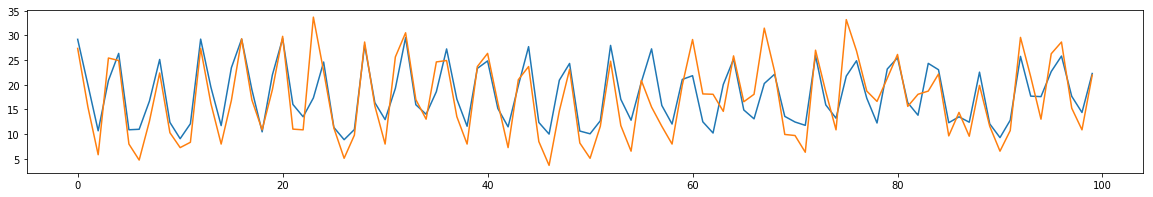

In [21]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

plt.rcParams["figure.figsize"] = (20,3)
index = 500

plt.plot(pred[index:index+100])
plt.plot(dev_y.values[index:index+100])

## 2. XGBoost

In [29]:
import xgboost as xgb
model = xgb.XGBRegressor(n_estimators=200, 
                         learning_rate=0.05, 
                         max_depth=15,
                         colsample_bytree=0.9,
                         gamma=0.4,
                         min_child_weight=7,
                         subsample=0.9,
                         reg_alpha=0.1,
                         seed=10,
                         n_jobs=-1)

In [30]:
%%time
pred = train_and_predict(model, train_x, train_y, dev_x)
evaluate(pred, dev_y)

RMSE : 4.2614
CPU times: user 7min 40s, sys: 4.15 s, total: 7min 44s
Wall time: 58.4 s


In [24]:
%%time
pred = iterative_train_and_predict(model, df, dev_x_iter)
evaluate(pred, dev_y)

Number of Dates = 966
>> 10 % >>>> 20 % >>>> 30 % >>>> 40 % >>>> 50 % >>>> 60 % >>>> 70 % >>>> 80 % >>>> 90 % >>>> 100 % >>
RMSE : 4.4419
CPU times: user 4d 12h 29min 34s, sys: 1h 15min 40s, total: 4d 13h 45min 15s
Wall time: 13h 47min


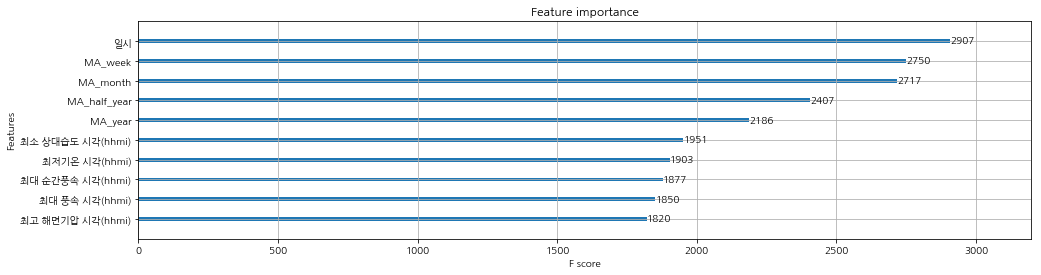

In [25]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

plt.rcParams['figure.figsize'] = (16,4)
plt.rcParams['font.family'] = 'NanumGothic'

xgb.plot_importance(model, max_num_features=10)

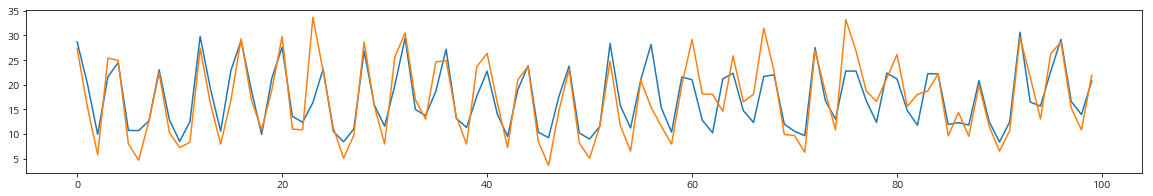

In [26]:
plt.rcParams["figure.figsize"] = (20,3)
index = 500

plt.plot(pred[index:index+100])
plt.plot(dev_y.values[index:index+100])